# 900KW WAXS Detector Workflow

In [103]:
import os, glob, re
import numpy as np
import matplotlib.pyplot as plt
from smi_analysis import SMI_beamline


#### Helper Functions

In [104]:
def plot_2d_image(data, ax, extent=None, aspect=None):
    ax.imshow(data,
        vmin=np.percentile(data,1),
        vmax=np.percentile(data,99),
        cmap='inferno',
        extent=extent,
        aspect=aspect,
        origin='upper')

def get_wa(file_name):
    match_obj = re.search(pattern='_wa(\d+.\d+)', string=file_name.split('/')[-1])

    return float(match_obj.groups()[0])

## Collect data file names into a list

In [105]:
!ls -l

total 25320
-rw-r--r--  1 wyssuser  staff   868325 Sep 24 15:50 900kw_example copy.ipynb
-rw-r--r--  1 wyssuser  staff  1120726 Sep 24 17:05 900kw_example.ipynb
-rw-rw-r--@ 1 wyssuser  staff  3656196 Sep 30  2021 900kw_wa0.0.tif
-rw-rw-r--@ 1 wyssuser  staff  3656196 Sep 30  2021 900kw_wa2.0.tif
-rw-rw-r--@ 1 wyssuser  staff  3656196 Sep 30  2021 900kw_wa20.0.tif


In [106]:
# Path to directory where data files are stored
data_path = os.getcwd()

# get all files within `data_path`
data_files = glob.glob(data_path + '/*')

# keep only file names
data_files = [f.split('/')[-1] for f in data_files]

# keep only .tif files
data_files = [f for f in data_files if f.endswith('.tif')]

# sort files by waxs detector rotation angle
data_files.sort(key=get_wa)

# make a list of all detector rotation angles
wa_list = [get_wa(f) for f in data_files]

print('Files Found: ', data_files)
print('WAXS Detector Angles: ', wa_list)


Files Found:  ['900kw_wa0.0.tif', '900kw_wa2.0.tif', '900kw_wa20.0.tif']
WAXS Detector Angles:  [0.0, 2.0, 20.0]


## Define SMI Geometry

Refer to the calibration tutorial to find `sdd` and `poni1` and `poni2`

In [107]:
sdd = 277           # mm
poni1 = 0.21603200  # m
poni2 = 0.0518690   # m

In [108]:
energy = 16.1                                       # keV
beam_center = [poni2/(172e-6), poni1/(172e-6)]      # pixels - 900kw pixel size = 172 um/px (see calibration tutorial)

smi = SMI_beamline.SMI_geometry(
    geometry='Transmission',                        # Transmission or Reflection
    sdd=sdd,                                        # mm
    wav=1E-10 * (12.39842/energy),                  # m
    center=beam_center,                             # pixels
    bs_pos=[[307, 1070]],                           # pixels - must be a list of a list and must be integer values
    detector='Pilatus900kw',
    det_angles=[np.deg2rad(v) for v in wa_list],    # radians
    alphai=np.deg2rad(0)                            # radians
)

# add data files to smi geometry
smi.open_data(data_path, data_files)

## Stitch Images Together

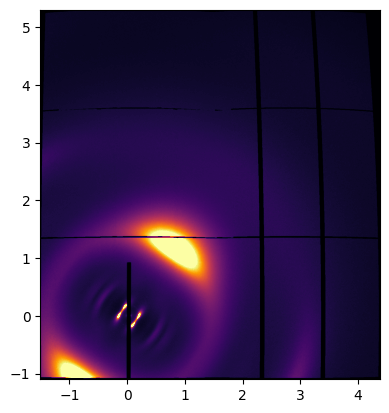

In [109]:
smi.stitching_data(interp_factor=1)

fig, ax = plt.subplots()
plot_2d_image(smi.img_st, ax, extent=[*smi.qp, *smi.qz])
plt.show()

## Caking Procedure

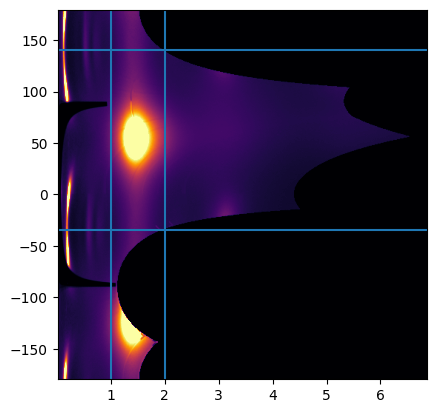

In [110]:
smi.caking()
fig, ax = plt.subplots()
aspect = abs(smi.q_cake[0]-smi.q_cake[-1]) / abs(smi.chi_cake[0] - smi.chi_cake[-1])
extent = [smi.q_cake[0], smi.q_cake[-1], smi.chi_cake[-1], smi.chi_cake[0]]
plot_2d_image(smi.cake, ax=ax, extent=extent, aspect=aspect)

ax.axvline(1)
ax.axvline(2)
ax.axhline(140)
ax.axhline(-35)
plt.show()

## Radial Integration

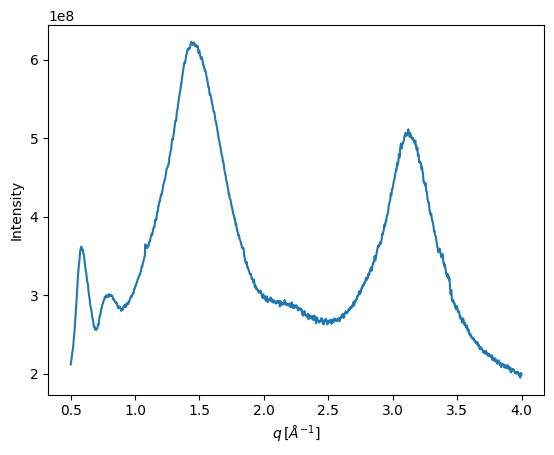

In [111]:
smi.radial_averaging(radial_range=(0.5,4))

plt.plot(smi.q_rad, smi.I_rad)
plt.xlabel('$q \, [\AA^{-1}]$')
plt.ylabel('Intensity')
plt.show()

## Azimuthal Integration

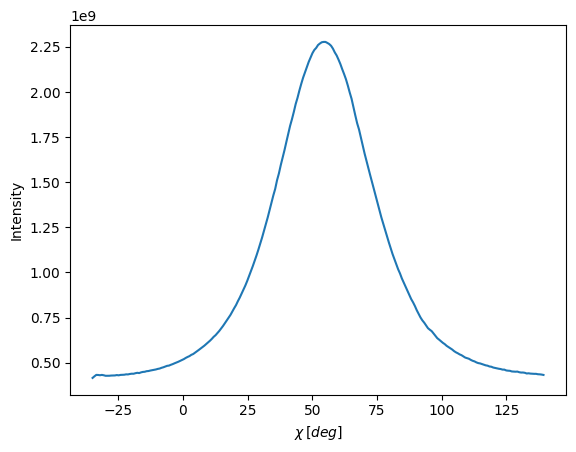

In [112]:
smi.azimuthal_averaging(radial_range=(1.0, 2.0), azimuth_range=(-35, 140))

plt.plot(smi.chi_azi, smi.I_azi)
plt.xlabel('$\chi \, [deg]$')
plt.ylabel('Intensity')
plt.show()